# 🏎️ F1 Pre-Race Excitement Forecaster

## 💭 Predictive Task

The goal of our project is to build a binary classification model that predicts whether a Formula 1 race will be **“Exciting”** (1) or **“Not Exciting”** (0) before the race begins.
All predictions must rely solely on pre-race features, such as:

- Qualifying results and grid spread
- Championship standings (point gaps, title contention)
- Circuit characteristics (altitude, layout properties)

The ground-truth labels are generated from post-race data using objective thresholds on:
- Number of DNFs
- Total overtakes

A race is labeled Exciting if it falls in the top 25% in either category.

## Background

Formula 1 is widely regarded as the pinnacle of motorsport, yet the excitement level of each Grand Prix can vary dramatically. Some races unfold as predictable processions, while others deliver unexpected chaos, dramatic overtakes, and major shifts in championship momentum. This inconsistency makes it difficult for casual viewers to decide which races are worth watching, and even dedicated fans often gravitate toward events that promise high action. Predicting that excitement before a race begins, however, is far from straightforward. The dynamics that shape a race’s entertainment value — grid order, competitive pressure, track layout, and environmental conditions — all interact in complex ways that are not immediately obvious.

In recent years, the narrative surrounding a race before it happens has become almost as influential as the race itself. Tight championship battles, surprising qualifying results, unusual track environments, or major penalties can all heighten expectations for an unpredictable event. Although excitement is inherently subjective, many measurable factors correlate with how action-packed a race turns out to be. Metrics such as overtakes, retirements, and field spread provide concrete signals of how dynamic a race was. These relationships motivate our central goal: to build a machine learning classifier capable of predicting a race’s entertainment value *strictly* from ***pre-race information***.

To explore this, we draw on historical Formula 1 data spanning 1950–2024, focusing on features that can be known before lights out — including qualifying performance, driver standings, and circuit characteristics. We then generate an objective “excitement” label using post-race metrics such as DNFs and total overtakes. This allows us to train and evaluate our model without introducing future information into the predictions. By combining pre-race context with well-defined labels, our project investigates whether it is possible to anticipate the entertainment potential of a Grand Prix ahead of time. Such a model can help casual fans choose which races to watch live and may provide broader insight into how pre-race conditions shape the dynamics of Formula 1 competition.

## 🔍 Prior Work

Research on predicting the entertainment value of sporting events has grown a lot in recent years, especially in football, basketball, and various motorsports. Most of that work, however, focuses on performance outcomes — things like predicting the race winner, estimating lap times, or modeling podium finishes. In Formula 1 specifically, there’s been work using historical timing data to estimate pace differences, applying machine learning to forecast pit strategies, or studying how track layout affects overtaking. These kinds of projects show that many aspects of a race can be anticipated using pre-race information.

For Formula 1, several Kaggle notebooks and independent analyses have also looked at how overtakes relate to circuit characteristics, how altitude or temperature impacts power units, and how qualifying gaps influence race-day competitiveness. A lot of these takeaways point toward similar themes: grid variability, championship pressure, and track features all play meaningful roles in shaping how a race plays out — which aligns with the features we build into our model.

What’s much less common is trying to classify the overall “excitement” of a race as its own prediction task. The few attempts that exist usually rely on fan surveys or subjective scoring systems, which can be inconsistent and hard to scale. 

Our approach differs in two important ways:

**Objective Labeling**:
- Instead of using opinions or ratings, we define excitement using measurable post-race metrics like DNFs and overtakes. This gives us a consistent, reproducible label.

**Strictly Pre-Race Features**:
- We only use information available before the race starts, which helps avoid data leakage — something not all prior work accounts for.

By combining insights from motorsport analytics with this stricter setup, our project pushes into a relatively under-explored space: trying to predict how entertaining a Formula 1 race will be before anyone has turned a wheel.

## 📊 Data

#### Dataset #1 — Formula 1 World Championship Dataset

Dataset Name: [Formula 1 World Championship (1950–2024)](https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020)

Number of observations: ~80,000+ records across all tables

Number of variables: Varies by table (5–20 columns each)

This dataset contains the official historical results from every Formula 1 race, including tables such as races, results, qualifying, driver_standings, circuits, and lap_times. Important variables include race metadata (year, round, circuit), driver finishing positions, qualifying times, lap-by-lap positions, and driver point standings. These variables represent concrete performance and contextual indicators such as competitiveness, grid spread, pace variability, and circuit characteristics. For preprocessing, we filtered the data to modern-era races (year ≥ 2000), handled null values, merged weather data, and removed irrelevant scheduling columns before feature engineering and label creation.

#### Dataset #2 — Formula 1 Weather Dataset

Dataset Name: [Formula 1 Race Weather Info (1950–2024)](https://www.kaggle.com/datasets/mariyakostyrya/formula-1-weather-info-1950-2024)

Number of observations: ~1,500

Number of variables: 10

This dataset provides race-day weather conditions such as temperature, precipitation, humidity, and wind speed for each Grand Prix. Key variables we use include temperature (float), precipitation (float), and a derived feature is_rain, which captures whether the track was wet. Weather serves as a proxy for external race conditions that can influence excitement, risk-taking, and chaos (e.g., wet races tend to produce more DNFs and overtakes). Preprocessing steps included converting timestamps into year/round identifiers, filling missing values with reasonable defaults, and merging the data into the main race table.

#### Dataset #3 — Combined Race-Level Dataset (Engineered)

Dataset Name: F1 Race-Level Modeling Dataset (Engineered)

Link: Locally created from dataset #1 and #2

Number of observations: 400–450 races (depending on filtering)

Number of variables: ~20 engineered features

This final dataset is constructed by merging the cleaned race metadata with pre-race features (qualifying spread, grid shake-ups, championship tension) and the weather variables. Additional post-race metrics from results and lap_times are used only to create the ground-truth excitement labels (DNFs → chaos score, position changes → action score). Preprocessing involved merging multiple CSVs on raceId, calculating new features, filtering to modern seasons, and ensuring no data leakage by keeping all post-race information strictly for label generation.

In [64]:
# --- Imports & Configuration ---
import pandas as pd
import numpy as np
import io
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
DATA_PATH = 'data/'  # Folder where you unzipped the Kaggle dataset
START_YEAR = 2000    # We focus on the modern era for data consistency

In [65]:
# --- Data Loading ---
def load_data():
    print("Loading Vopani Dataset CSVs...")
    # Load core files with '\N' handling for nulls
    races = pd.read_csv(f'{DATA_PATH}races.csv', na_values='\\N')
    results = pd.read_csv(f'{DATA_PATH}results.csv', na_values='\\N')
    status = pd.read_csv(f'{DATA_PATH}status.csv', na_values='\\N')
    qualifying = pd.read_csv(f'{DATA_PATH}qualifying.csv', na_values='\\N')
    standings = pd.read_csv(f'{DATA_PATH}driver_standings.csv', na_values='\\N')
    circuits = pd.read_csv(f'{DATA_PATH}circuits.csv', na_values='\\N')
    lap_times = pd.read_csv(f'{DATA_PATH}lap_times.csv', na_values='\\N')
    weather = pd.read_csv(f'{DATA_PATH}weather.csv', na_values='\\N')
    print("Datasets are loaded in...")

    return races, results, status, qualifying, standings, circuits, lap_times, weather

# Load the raw dataframes
races_df, results_df, status_df, qual_df, stand_df, circuits_df, laps_df, weather_df = load_data()

Loading Vopani Dataset CSVs...
Datasets are loaded in...


In [66]:
races_df.sort_values('year', inplace=True)
races_df.head()

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
838,839,1950,7,14,Italian Grand Prix,1950-09-03,NaN,http://en.wikipedia.org/wiki/1950_Italian_Gran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
837,838,1950,6,55,French Grand Prix,1950-07-02,NaN,http://en.wikipedia.org/wiki/1950_French_Grand...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
836,837,1950,5,13,Belgian Grand Prix,1950-06-18,NaN,http://en.wikipedia.org/wiki/1950_Belgian_Gran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
835,836,1950,4,66,Swiss Grand Prix,1950-06-04,NaN,http://en.wikipedia.org/wiki/1950_Swiss_Grand_...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
834,835,1950,3,19,Indianapolis 500,1950-05-30,NaN,http://en.wikipedia.org/wiki/1950_Indianapolis...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
weather_df.head()

,temperature,precipitation,windspeed,round,name,datetime
0,15.8,0.0,18.8,1,British Grand Prix,1950-05-13 12:00:00
1,23.1,0.0,17.3,2,Monaco Grand Prix,1950-05-21 12:00:00
2,19.5,0.2,12.5,3,Indianapolis 500,1950-05-30 14:00:00
3,22.8,0.0,6.1,4,Swiss Grand Prix,1950-06-04 14:00:00
4,17.5,0.0,15.9,5,Belgian Grand Prix,1950-06-18 12:00:00


In [68]:
# --- Cleaning & Weather Merging ---
def clean_and_merge_weather(races, weather):
    print("Processing & Merging Weather Data...")
    
    # 1. Extract Year from Weather Date
    weather['datetime'] = pd.to_datetime(weather['datetime'])
    weather['year'] = weather['datetime'].dt.year
    
    # 2. Create "Is Rain" Feature
    # Logic: If precipitation > 0.0, the track is wet.
    weather['is_rain'] = (weather['precipitation'] > 0.1).astype(int)


    # 3. Merge Weather with Official Race List
    # We join on ['year'] to align the weather with the correct Race ID
    races = races.drop(columns=['round','time'], axis=1)  # Drop 'round' to avoid merge issues
    merged_races = pd.merge(
        races, 
        weather[['year', 'name', 'temperature', 'precipitation', 'is_rain']], 
        on=['year','name'], 
        how='left'
    ).sort_values(by='year', ascending=True)

    merged_races = merged_races[merged_races['name'] != 'Indianapolis 500']

    # 4. Filter for Modern Era (2000+)
    merged_races = merged_races[merged_races['year'] >= START_YEAR].copy()
    
    # 5. Handle Missing Weather (Missing)
    # We fill with defaults (Dry, 20°C) so the model doesn't crash
    merged_races['precipitation'] = merged_races['precipitation'].fillna(0)
    merged_races['temperature'] = merged_races['temperature'].fillna(20.0)
    merged_races['is_rain'] = merged_races['is_rain'].fillna(0).astype(int)

    drop_cols = [
        'url', 
        'fp1_date', 'fp1_time', 
        'fp2_date', 'fp2_time', 
        'fp3_date', 'fp3_time', 
        'quali_date', 'quali_time', 
        'sprint_date', 'sprint_time'
    ]
    
    # Only drop columns that actually exist in the dataframe to avoid errors
    cols_to_drop = [c for c in drop_cols if c in merged_races.columns]
    
    df_clean = merged_races.drop(columns=cols_to_drop)
    
    # print(f"Total Races processed: {merged_races.shape[0]}")
    return df_clean

# Execute Cleaning
main_races = clean_and_merge_weather(races_df, weather_df)
# Apply the cleaning

# Verify what's left
print("Columns kept:", main_races.columns.tolist())
main_races

Processing & Merging Weather Data...
Columns kept: ['raceId', 'year', 'circuitId', 'name', 'date', 'temperature', 'precipitation', 'is_rain']


,raceId,year,circuitId,name,date,temperature,precipitation,is_rain
662,165,2000,7,Canadian Grand Prix,2000-06-18,14.4,0.5,1
661,174,2000,2,Malaysian Grand Prix,2000-10-22,28.8,0.1,0
660,172,2000,19,United States Grand Prix,2000-09-24,14.1,1.9,1
659,171,2000,14,Italian Grand Prix,2000-09-10,24.1,0.0,0
658,170,2000,13,Belgian Grand Prix,2000-08-27,15.4,0.5,1
...,...,...,...,...,...,...,...,...
1102,1135,2024,39,Dutch Grand Prix,2024-08-25,18.1,0.0,0
1101,1134,2024,13,Belgian Grand Prix,2024-07-28,19.4,0.0,0
1123,1131,2024,70,Austrian Grand Prix,2024-06-30,29.0,0.0,0
1111,1132,2024,9,British Grand Prix,2024-07-07,15.9,0.1,0


In [69]:
# --- Generating Labels (Y) ---
def generate_labels(races, results, status, laps):
    print("Calculating Excitement Labels...")
    
    # counts of unique race id
    target_race_ids = races['raceId'].unique()
    
    # --- A. Calculate CHAOS Score (DNFs) ---
    # Chaos is a metric determined by how drivers finished a race out of the participating drivers
    # The drivers that finished a race, the more likely that the chaos score is lowered

    # Copy from results df to get filtered unique race ids
    results_filtered = results[results['raceId'].isin(target_race_ids)].copy()
    
    # Status IDs 1, 11-19 represent normal finishes. Everything else is a DNF.
    # In status.csv, ids 1 is considered a normal finish, ids 11-19 refer to how many laps the leader lapped this driver
    # The # of laps that the driver was lapped is id - 10 (e.g 11-10 = +1 laps)
    # We will consider all types of finishes as a safe finish
    normal_finish_ids = [1] + list(range(11, 20))

    # Create a new dataframe column name 'is_dnf' 
    # Checks if drivers in results_filtered had a normal finish
    # If true, the tilde inverts (NOT operator) to false and vice versa
    results_filtered['is_dnf'] = ~results_filtered['statusId'].isin(normal_finish_ids)
    
    # Group results_filtered by the race and sum everything in the 'is_dnf' column
    # Rename the column of the resulting dataframe into a chaos score
    chaos_df = results_filtered.groupby('raceId')['is_dnf'].sum().reset_index()
    chaos_df.rename(columns={'is_dnf': 'chaos_score'}, inplace=True)
    
    # --- B. Calculate ACTION Score (Overtakes/Position Changes) ---
    # Filter laps from laptimes.csv with each unique race ids.
    laps_filtered = laps[laps['raceId'].isin(target_race_ids)].copy()
    laps_filtered.sort_values(['raceId', 'driverId', 'lap'], inplace=True)
    
    # Calculate position change from previous lap
    # Sort by race, driver, and position
    # This line takes a unique driver's position in between laps
    # diff() computes the difference of current row to previous row
    laps_filtered['pos_change'] = laps_filtered.groupby(['raceId', 'driverId'])['position'].diff().abs()

    # Group results by new 'pos_change' column to include only the race and position and sum on the position values
    # High values mean more position changes = suggests more action
    # Low values mean steady position placement = suggest "boring" race
    action_df = laps_filtered.groupby('raceId')['pos_change'].sum().reset_index()
    action_df.rename(columns={'pos_change': 'action_score'}, inplace=True)
    
    # --- C. Create Final Label ---
    # Merge the previous metrics given each unique race
    metrics = races[['raceId']].merge(chaos_df, on='raceId', how='left')
    metrics = metrics.merge(action_df, on='raceId', how='left').fillna(0)
    
    # Define "Exciting" as Top 25% in Chaos OR Top 25% in Action
    chaos_thresh = metrics['chaos_score'].quantile(0.75)
    action_thresh = metrics['action_score'].quantile(0.75)
    
    metrics['is_exciting'] = (
        (metrics['chaos_score'] > chaos_thresh) | 
        (metrics['action_score'] > action_thresh)
    ).astype(int)
    
    print(f"Thresholds -> Chaos: >{chaos_thresh} DNFs, Action: >{action_thresh} Changes")
    return metrics[['raceId', 'is_exciting']]

# Execute Label Generation
labels_df = generate_labels(main_races, results_df, status_df, laps_df)
print(labels_df)

Calculating Excitement Labels...
Thresholds -> Chaos: >7.0 DNFs, Action: >377.5 Changes
     raceId  is_exciting
0       165            1
1       174            1
2       172            1
3       171            1
4       170            0
..      ...          ...
474    1135            0
475    1134            1
476    1131            1
477    1132            0
478    1144            0

[479 rows x 2 columns]


## EDA

Merge qualifying lap times with year to allow for the computation of future features

In [70]:
qual_df = qual_df.merge(
    races_df[['raceId', 'year', 'round']],
    on='raceId',
    how='left'
)

#### Grid Spread
Grid spread measures how mixed or tight the starting grid is.
We compute it as the standard deviation of the qualifying positions for a race:
- Low grid spread → the grid is tightly packed (fast cars at the front, slow cars at the back).
- High grid spread → the grid is more scattered (drivers “out of order” relative to usual performance)

Races with larger grid spread values are typically more chaotic, because faster cars have to recover from deeper in the pack. This doesn’t guarantee an exciting race on its own, but it provides reliable contextual information.

In [71]:
# ---------- GRID SPREAD ----------
qual_grid = qual_df[["raceId", "driverId", "position"]].dropna()

grid_spread = (
    qual_grid.groupby("raceId")["position"]
    .std()
    .reset_index()
    .rename(columns={"position": "grid_spread"})
)

In [72]:
grid_spread.describe()


,raceId,grid_spread
count,494.000000,494.000000
mean,633.838057,6.274969
std,432.494962,0.513776
min,1.000000,5.338539
25%,128.750000,5.916080
50%,879.500000,5.916080
75%,1013.750000,6.493587
max,1144.000000,8.225975


#### Grid shake-up
Grid shake-up measures how far drivers qualified from their usual season performance. Bigger shake-up means the grid is more unusual. These out-of-position starts typically lead to more overtakes and more unpredictable race behavior, making it a subtle but meaningful predictor of excitement.

In [ ]:
# ---------- GRID SHAKE-UP ----------
# seasonal qualifying average per driver
qual_df = qual_df.sort_values(['year', 'round', 'driverId'])

season_avg = (
    qual_df.groupby(['year', 'driverId'])['position']
    .mean()
    .reset_index()
    .rename(columns={'position': 'season_avg_position'})
)


qual_pos = qual_df.merge(season_avg, on=["year", "driverId"], how="left")
qual_pos["shake"] = (qual_pos["position"] - qual_pos["season_avg_position"]).abs()
'''
qual_df['season_avg_pos'] = (
    qual_df.groupby(['year', 'driverId'])['position']
    .transform(lambda x: x.expanding().mean().shift(1))
)
qual_df['season_avg_pos'] = qual_df['season_avg_pos'].fillna(qual_df['position'])

# 4. Calculate the Shake
# How far is their current grid slot from their running average?
qual_df['shake'] = (qual_df['position'] - qual_df['season_avg_pos']).abs()
'''
grid_shakeup = (
    qual_df.groupby("raceId")["shake"]
    .mean()
    .reset_index()
    .rename(columns={"shake": "grid_shakeup"})
)


     raceId  grid_shakeup
0         1      0.000000
1         2      2.000000
2         3      3.400000
3         4      3.233333
4         5      2.450000
..      ...           ...
489    1140      3.430409
490    1141      5.059211
491    1142      4.237876
492    1143      2.979481
493    1144      3.317250

[494 rows x 2 columns]


In [ ]:
grid_shakeup.describe() 

,raceId,grid_shakeup
count,494.000000,494.000000
mean,633.838057,2.543044
std,432.494962,1.002570
min,1.000000,0.000000
25%,128.750000,2.063570
50%,879.500000,2.544568
75%,1013.750000,3.109263
max,1144.000000,6.064655


#### Title Tension
Title tension summarizes how close the championship fight is. While it mainly captures fan hype rather than hard race dynamics, close title battles can increase driver aggression and strategic risk, making it a useful context feature even if the direct correlation with our label is small.

In [75]:
# ---------- TITLE TENSION ----------
title_tension = (
    stand_df.groupby("raceId")
    .apply(lambda df: df.sort_values("points", ascending=False).head(3)["points"].std())
    .reset_index(name="title_tension")
)

/var/folders/bj/d7llsmyn05b5rg_c41j3zvf40000gn/T/ipykernel_35671/4244748648.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sort_values("points", ascending=False).head(3)["points"].std())


In [76]:
title_tension.describe()

,raceId,title_tension
count,1125.000000,1125.000000
mean,565.710222,17.505845
std,328.813817,20.731180
min,1.000000,0.000000
25%,282.000000,4.618802
50%,563.000000,10.440307
75%,845.000000,21.385353
max,1144.000000,183.930240


#### Altitude
Altitude is a track-level feature that affects engine power, cooling, and drag. Certain high-altitude tracks tend to produce more mechanical issues or unusual pace differences. This makes altitude a small but potentially relevant contextual factor, even though its direct correlation with excitement is mild.

In [77]:
# ---------- ALTITUDE ----------
altitude = circuits_df[["circuitId", "alt"]].rename(columns={"alt": "altitude"})

Our pre-race features reflect different aspects of the race weekend: grid spread measures how mixed the starting order is; grid shake-up captures how unusual drivers’ qualifying results are relative to their season; title tension describes the competitive pressure in the championship; and altitude represents circuit-specific environmental difficulty. While none of these features individually guarantee an exciting race, each provides contextual cues that, when combined, contribute meaningful predictive signal.

In [78]:
# ---------- MERGE EVERYTHING ----------
eda_df = (
    main_races
    .merge(labels_df, on="raceId", how="left")
    .merge(grid_spread, on="raceId", how="left")
    .merge(grid_shakeup, on="raceId", how="left")
    .merge(title_tension, on="raceId", how="left")
    .merge(altitude, on="circuitId", how="left")
)
eda_df.head()

,raceId,year,circuitId,name,date,temperature,precipitation,is_rain,is_exciting,grid_spread,grid_shakeup,title_tension,altitude
0,165,2000,7,Canadian Grand Prix,2000-06-18,14.4,0.5,1,1,NaN,NaN,13.316656,13
1,174,2000,2,Malaysian Grand Prix,2000-10-22,28.8,0.1,0,1,NaN,NaN,17.521415,18
2,172,2000,19,United States Grand Prix,2000-09-24,14.1,1.9,1,1,NaN,NaN,12.767145,223
3,171,2000,14,Italian Grand Prix,2000-09-10,24.1,0.0,0,1,NaN,NaN,10.440307,162
4,170,2000,13,Belgian Grand Prix,2000-08-27,15.4,0.5,1,0,NaN,NaN,6.506407,401


In [79]:
eda_df.dropna(inplace=True)

In [80]:
feature_df = eda_df.drop(columns=['name','year', 'date', 'circuitId', 'raceId'])
feature_df.describe()

,temperature,precipitation,is_rain,is_exciting,grid_spread,grid_shakeup,title_tension,altitude
count,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000
mean,22.894713,0.124598,0.151724,0.377011,6.180269,2.593129,30.108430,206.048276
std,4.997935,0.412944,0.359166,0.485196,0.422653,0.987414,27.579961,366.874889
min,8.500000,0.000000,0.000000,0.000000,5.338539,0.000000,0.000000,-7.000000
25%,19.200000,0.000000,0.000000,0.000000,5.916080,2.104072,9.539392,10.000000
50%,22.800000,0.000000,0.000000,0.000000,5.916080,2.591667,22.590558,103.000000
75%,26.650000,0.000000,0.000000,1.000000,6.493587,3.156818,43.646252,228.000000
max,37.100000,4.200000,1.000000,1.000000,7.071068,6.064655,183.930240,2227.000000


In [81]:
features = [
    "grid_spread", "grid_shakeup", "title_tension",
    "altitude", "temperature", "precipitation", "is_rain"
]

eda_df[features + ["is_exciting"]].corr()["is_exciting"]

grid_spread      0.311297
grid_shakeup    -0.110295
title_tension    0.008807
altitude        -0.074519
temperature      0.000824
precipitation    0.021459
is_rain          0.014772
is_exciting      1.000000
Name: is_exciting, dtype: float64

### Grid Spread of Exciting vs Non-Exciting Races

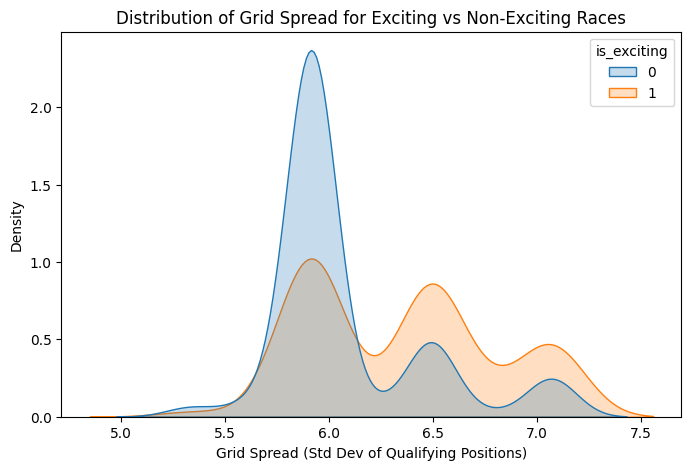

In [82]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=eda_df, x="grid_spread", hue="is_exciting", fill=True, common_norm=False)
plt.title("Distribution of Grid Spread for Exciting vs Non-Exciting Races")
plt.xlabel("Grid Spread (Std Dev of Qualifying Positions)")
plt.show()

This plot shows how exciting vs non-exciting races have more variability in grid spread. From the plot we can see:
- Non-exciting races(blue) bluster **very tightly** around grid spread (roughly 5.8-6.0)
- Exciting races (orange) are more spread out, with multiple bumps around 5.8, 6.5 and even >= 7.0

In other words, when grid spread is small (tight grid), sometimes very mied (large spread). However, non-exciting races have a consistent, predictable grid spread.

This makes intuitive F1 sense:

- If the grid is very orderly → predictable race → usually boring
- If the grid is very mixed → cars out of position → more action

But exciting races can ALSO come from tight grids → high pressure → chaos

Hence the multi-peak shape for exciting races.

### Rain and Race Excitement

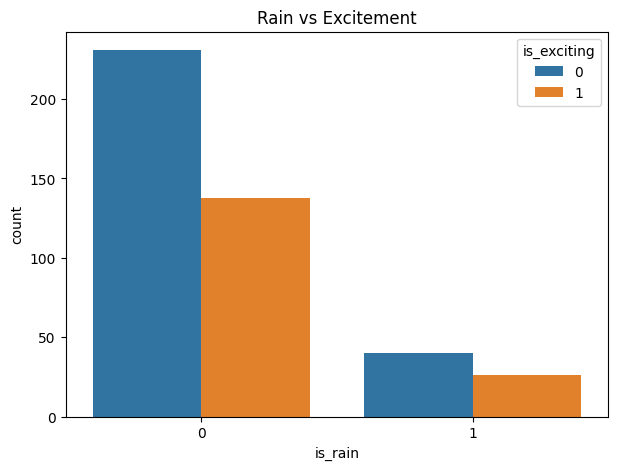

In [83]:
plt.figure(figsize=(7,5))
sns.countplot(data=eda_df, x="is_rain", hue="is_exciting")
plt.title("Rain vs Excitement")
plt.show()

In [84]:
rain_summary = (
    eda_df.groupby('is_rain')['is_exciting']
          .mean()
          .rename({0: 'Dry', 1: 'Wet'})
)
rain_summary

is_rain
Dry    0.373984
Wet    0.393939
Name: is_exciting, dtype: float64

In [85]:
rain_counts = eda_df[['is_rain', 'is_exciting']].value_counts().unstack(fill_value=0)

rain_counts


is_exciting,0,1
is_rain,,
0,231,138
1,40,26


Even though the increase is modest, it suggests that rain does tilt the race toward being more exciting, which matches long-standing F1 intuition. Rain tends to create more variability — slippery conditions, strategy divergence, higher skill gaps, and more driver mistakes — all of which can contribute to chaos or unpredictability.

So while rain isn’t a dominant predictor of excitement, it’s not irrelevant either.
The data shows a real effect — just not a dramatic one.

### Grid Shake-Up for Exciting vs Non-Exciting Races

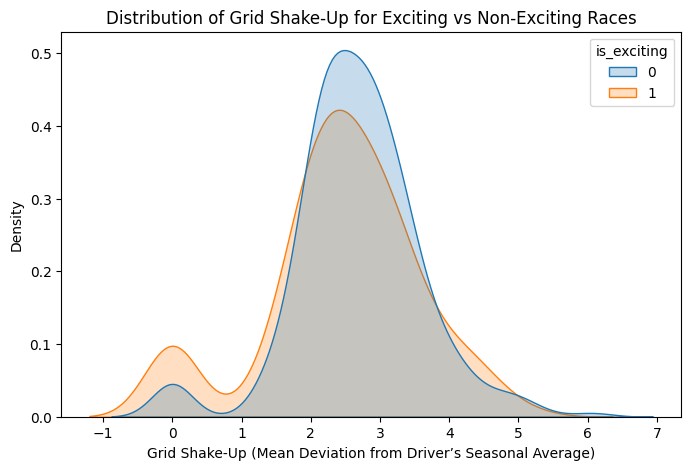

In [86]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=eda_df, x="grid_shakeup", hue="is_exciting", fill=True, common_norm=False)
plt.title("Distribution of Grid Shake-Up for Exciting vs Non-Exciting Races")
plt.xlabel("Grid Shake-Up (Mean Deviation from Driver’s Seasonal Average)")
plt.show()

#### Grid Shake-Up vs. Race Excitement

Grid shake-up measures how unusual the starting grid is compared to each driver’s typical qualifying performance that season. Higher shake-up values mean more drivers are starting far from where they “normally” qualify (e.g., a top driver starting P12, or a midfield driver unexpectedly lining up P5).

The KDE plot below compares the distribution of shake-up between exciting and non-exciting races:

- Both groups peak around 2.0–2.5, meaning most races involve some moderate amount of qualifying variability.

- The curve for exciting races is slightly shifted to the right, showing more density between 2.5–4.0.

- This suggests that exciting races tend to have a bit more qualifying chaos — cars starting out of position, which naturally leads to more overtaking and more dynamic race scenarios.

Even though the difference between the two distributions is subtle, it aligns with Formula 1 intuition:
When the grid is mixed up, the race is usually more eventful.
However, the heavy overlap also makes it clear that qualifying shake-up is not the sole source of excitement — many unpredictable factors on race day (weather, crashes, safety cars, tyre issues) can overshadow what happens on Saturday.

Exciting races show a slightly higher grid shake-up distribution, meaning more drivers start out of position compared to their seasonal average — a factor that tends to lead to more overtakes and race variability.